### Env Config

In [149]:
CLASSIFICACAO_DF = 'PF' # PJ ou PF

In [150]:
%%capture
%pip install pandas matplotlib numpy

In [151]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from datetime import datetime, timedelta

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.display.float_format = '{:.2f}'.format

In [152]:
df = pd.read_parquet('data/refined/df.parquet')

In [153]:
pf = df[df['ct_classificacao'] == 'PF']
pj = df[df['ct_classificacao'] == 'PJ']
CLASSIFICACOES = {
	'PF': pf,
	'PJ': pj
}

In [154]:
df = CLASSIFICACOES[CLASSIFICACAO_DF]

## Métricas de Contratação

### Análise do potencial financeiro por Porte dos Clientes

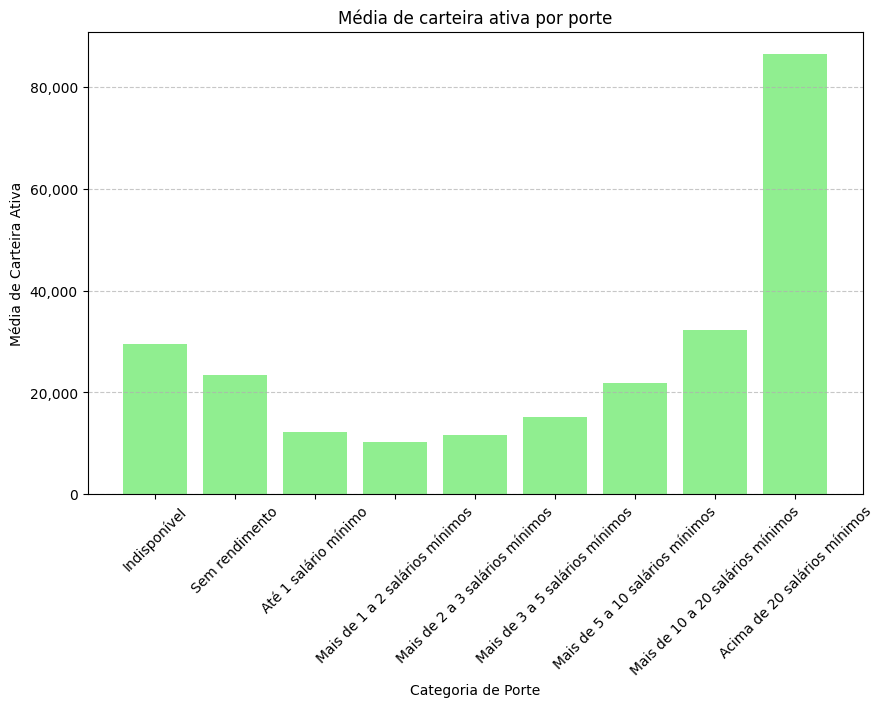

In [155]:
carteira_ativa_por_porte = df.groupby('ct_porte')['vl_media_carteira_ativa_por_operacao'].mean()

carteira_ativa_por_porte = carteira_ativa_por_porte.reindex(ordem)

carteira_ativa_por_porte = carteira_ativa_por_porte.dropna()

plt.figure(figsize=(10, 6))
plt.bar(carteira_ativa_por_porte.index, carteira_ativa_por_porte.values, color='lightgreen')
plt.title('Média de carteira ativa por porte')
plt.xlabel('Categoria de Porte')
plt.ylabel('Média de Carteira Ativa')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.show()

### Análise de Riscos por Porte dos Clientes

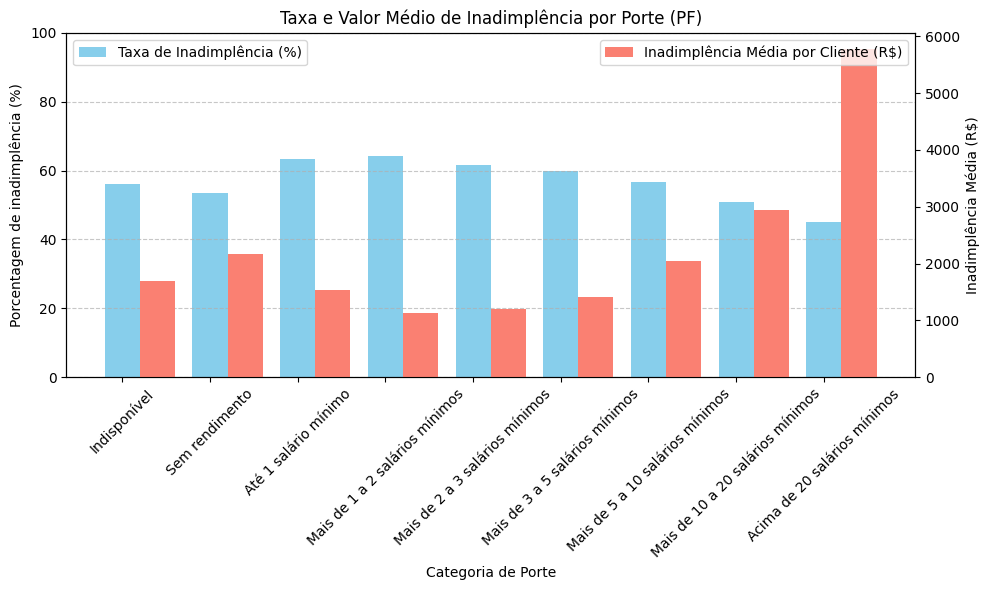

In [156]:
inadimplentes = df[df['vl_carteira_inadimplida_arrastada'] != 0.00]

inadimplentes_por_porte = inadimplentes.groupby('ct_porte').size() / df.groupby('ct_porte').size() * 100

inadimplencia_media_por_cliente = inadimplentes.groupby('ct_porte')['vl_media_carteira_inadimplida_por_operacao'].mean()

ordem = [
    "Indisponível",
    "Sem rendimento",
    "Micro",
    "Pequeno",
    "Médio",
    "Grande",
    "Até 1 salário mínimo",
    "Mais de 1 a 2 salários mínimos",
    "Mais de 2 a 3 salários mínimos",
    "Mais de 3 a 5 salários mínimos",
    "Mais de 5 a 10 salários mínimos",
    "Mais de 10 a 20 salários mínimos",
    "Acima de 20 salários mínimos"
]

inadimplentes_por_porte = pd.Series(
    inadimplentes_por_porte.values,
    index=inadimplentes_por_porte.index,
    dtype="category"
).reindex(ordem).dropna()

inadimplencia_media_por_cliente = pd.Series(
    inadimplencia_media_por_cliente.values,
    index=inadimplencia_media_por_cliente.index,
    dtype="category"
).reindex(ordem).dropna()

largura_barra = 0.4

fig, ax1 = plt.subplots(figsize=(10, 6))

posicoes = range(len(inadimplentes_por_porte.index))

ax1.bar(posicoes, inadimplentes_por_porte.values, color='skyblue', label='Taxa de Inadimplência (%)', width=largura_barra, align='center')

ax2 = ax1.twinx()

ax2.bar([p + largura_barra for p in posicoes], inadimplencia_media_por_cliente.values, color='salmon', label='Inadimplência Média por Cliente (R$)', width=largura_barra, align='center')

ax1.set_title(f'Taxa e Valor Médio de Inadimplência por Porte ({CLASSIFICACAO_DF})')
ax1.set_xlabel('Categoria de Porte')
ax1.set_ylabel('Porcentagem de inadimplência (%)')
ax2.set_ylabel('Inadimplência Média (R$)')

ax1.set_xticks([p for p in posicoes])
ax1.set_xticklabels(inadimplentes_por_porte.index, rotation=45)

ax1.set_ylim(0, 100)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

ax1.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### Entendendo como o risco mudou ao longo dos anos

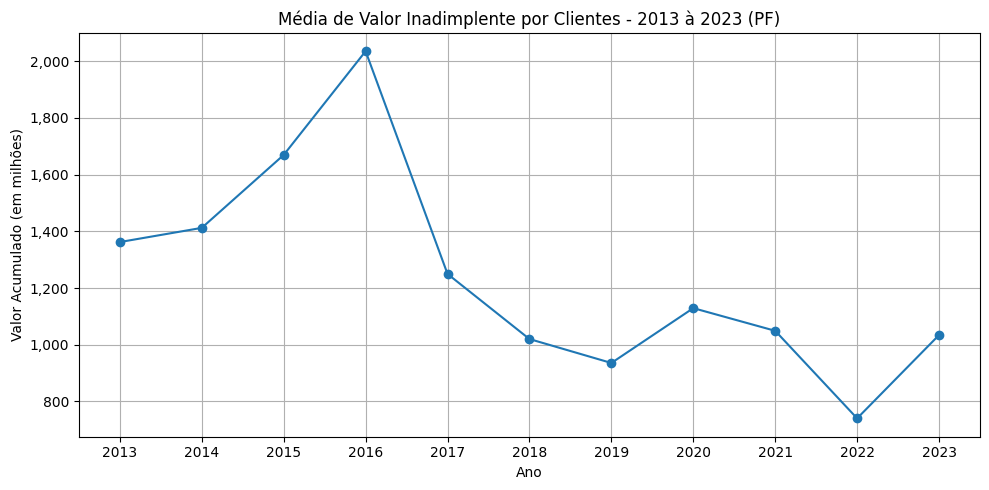

In [157]:
edited_df = df[df['dt_data_base'] > pd.to_datetime('2013-01-01')]
edited_df = edited_df[edited_df['dt_data_base'] < pd.to_datetime('2023-12-01')]

edited_df['Ano'] = edited_df['dt_data_base'].dt.year

resultados = edited_df.groupby('Ano')['vl_media_carteira_inadimplida_por_operacao'].mean()

plt.figure(figsize=(10, 5))
plt.plot(resultados.index, resultados, marker='o')

plt.title(f'Média de Valor Inadimplente por Clientes - 2013 à 2023 ({CLASSIFICACAO_DF})')
plt.xlabel('Ano')
plt.ylabel('Valor Acumulado (em milhões)')
plt.grid(True)
plt.xticks(resultados.index)

plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.tight_layout()
plt.show()

## Decisões de Estratégicas de Negócio

### Vale a pena alocar esforço/recursos para gerenciar empréstimos com mais quantidade de parcelas?

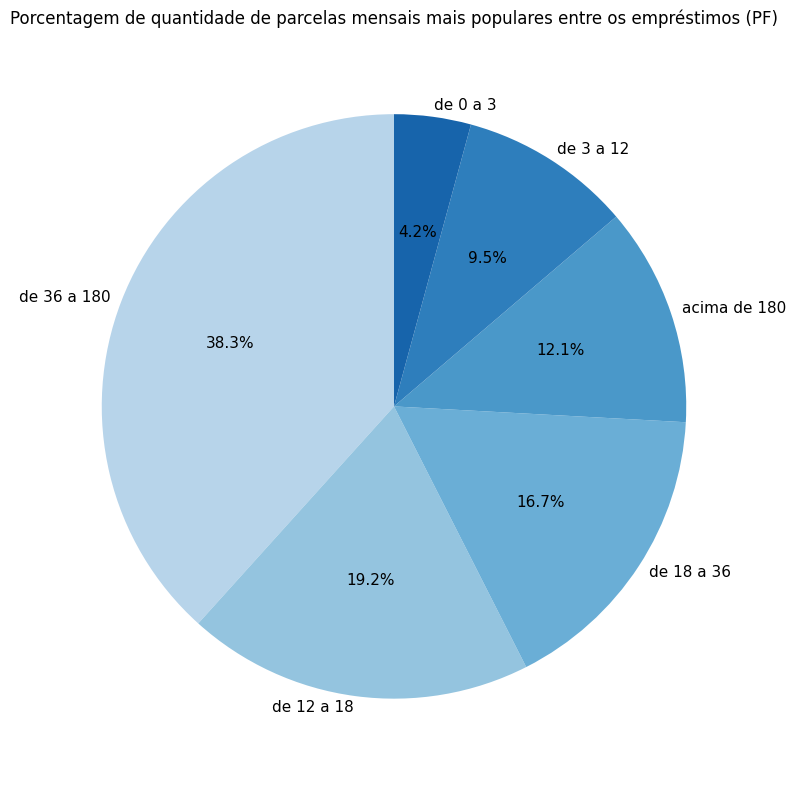

In [158]:
data_atual = datetime.today()
data_limite = data_atual - timedelta(days=36*30)
df_filtered = df[df['dt_data_base'] > pd.to_datetime(data_limite)]

LABELS = {
    '> 180': 'acima de 180',
    '36-180': 'de 36 a 180',
    '18-36': 'de 18 a 36',
    '12-18': 'de 12 a 18',
    '3-12': 'de 3 a 12',
    '0-3': 'de 0 a 3'
}

grouped = df_filtered['ct_faixa_meses_ate_vencimento'].value_counts(normalize=True) * 100
labels_mapeados = [LABELS.get(label, label) for label in grouped.index]

num_colors = len(grouped)
colors = plt.get_cmap('Blues')(np.linspace(0.3, 0.8, num_colors))


plt.figure(figsize=(8, 8))
plt.pie(
    grouped.values,
    labels=labels_mapeados,
    autopct='%1.1f%%',
    colors=colors,
    startangle=90,
    labeldistance=1.04,
    textprops={'fontsize': 11}
)
plt.axis('equal')
plt.title(f'Porcentagem de quantidade de parcelas mensais mais populares entre os empréstimos ({CLASSIFICACAO_DF})')
plt.tight_layout()
plt.show()

### Distribuição de Clientes por Estado

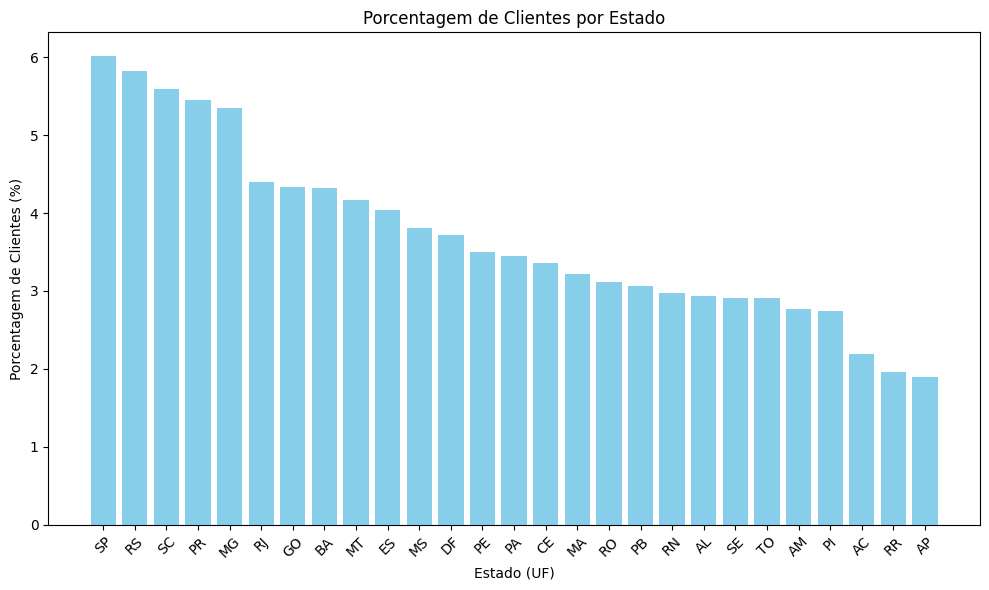

In [159]:
state_counts = df['ct_uf'].value_counts()

state_percentage = (state_counts / state_counts.sum()) * 100

state_percentage = state_percentage.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(state_percentage.index, state_percentage.values, color='skyblue')
plt.xlabel('Estado (UF)')
plt.ylabel('Porcentagem de Clientes (%)')
plt.title('Porcentagem de Clientes por Estado')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## A definir

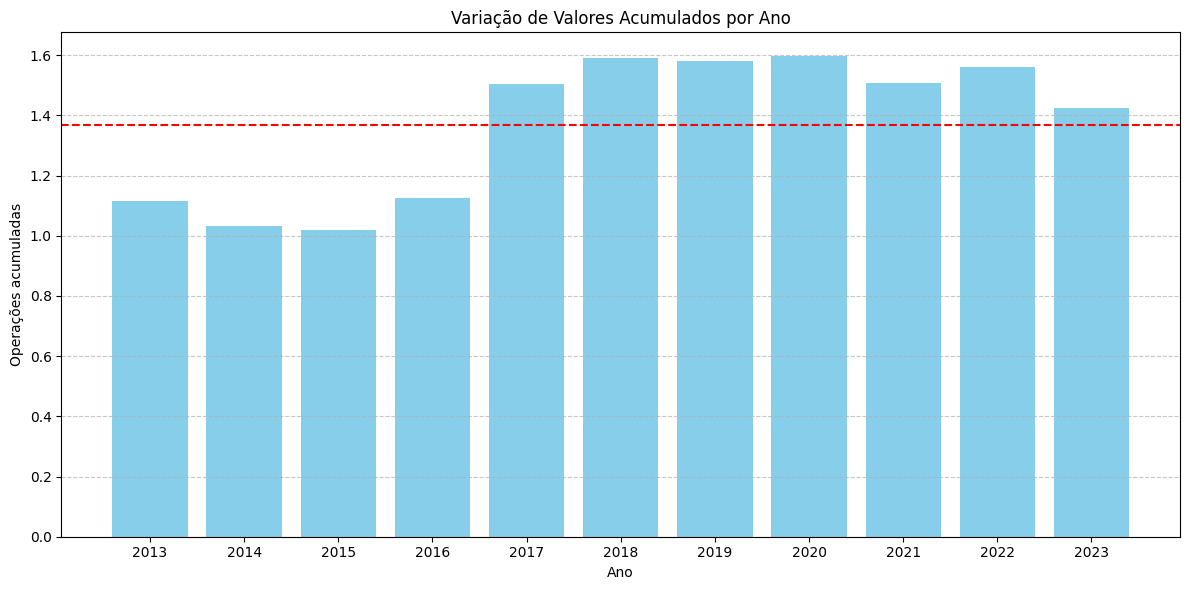

In [160]:
anos = ['2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']

df_filtrado = df[df['nu_numero_de_operacoes'] > 15]

df_filtrado = df[df['dt_data_base'] > pd.to_datetime('2013-01-01')]
df_filtrado = df_filtrado[df_filtrado['dt_data_base'] < pd.to_datetime('2023-12-01')]

df_filtrado['Ano'] = df_filtrado['dt_data_base'].dt.year

q1 = df_filtrado['nu_numero_de_operacoes'].quantile(0.25)
q3 = df_filtrado['nu_numero_de_operacoes'].quantile(0.75)
iqr = q3 - q1

limite_inferior = q1 - 1.5 * iqr
limite_superior = q3 + 1.5 * iqr

df_sem_outliers = df_filtrado[(df_filtrado['nu_numero_de_operacoes'] >= limite_inferior) & (df_filtrado['nu_numero_de_operacoes'] <= limite_superior)]

resultados = []

for ano in anos:
    df_ano_especifico = df_sem_outliers[df_sem_outliers['Ano'] == int(ano)]  
    valor_acumulado = df_ano_especifico['nu_numero_de_operacoes'].sum()
    resultados.append(valor_acumulado)

def millions(x, pos):
    return f'{x * 1e-6:.1f}'  

plt.figure(figsize=(12, 6))
bars = plt.bar(anos, resultados, color='skyblue')

media = np.mean(resultados)
plt.axhline(y=media, color='red', linestyle='--', label='Média: {:.1f} milhões'.format(media * 1e-6))

plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(millions))

plt.xlabel('Ano')
plt.ylabel('Operações acumuladas')
plt.title('Variação de Valores Acumulados por Ano')

plt.grid(axis='y', linestyle='--', alpha=0.7)  
plt.tight_layout() 
plt.show()

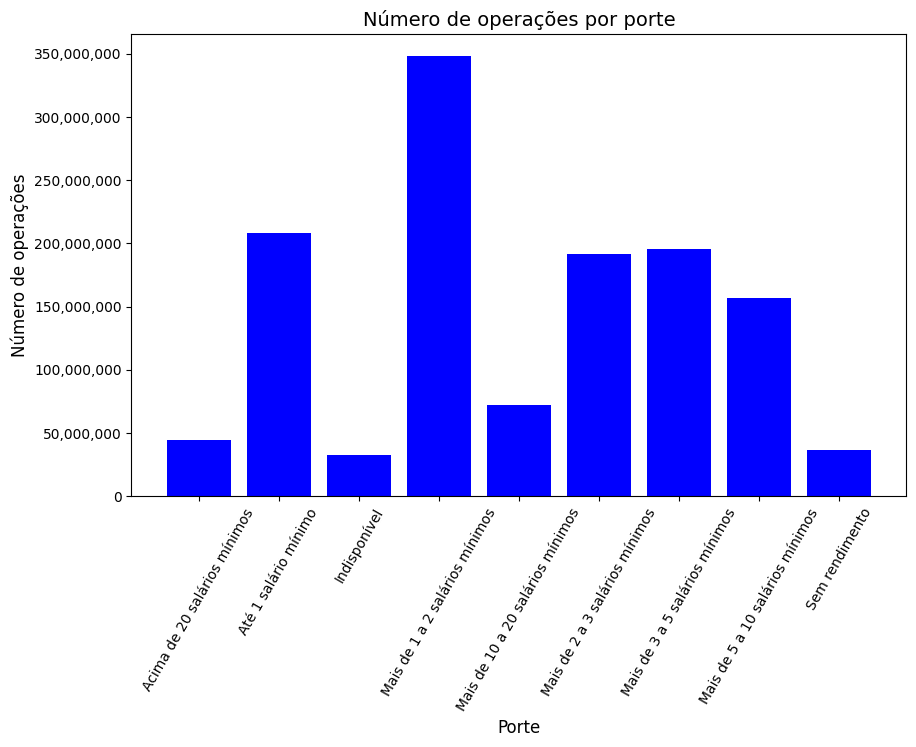

In [161]:
df_grouped = df.groupby('ct_porte')['nu_numero_de_operacoes'].sum().reset_index()

df_grouped = df_grouped[df_grouped['nu_numero_de_operacoes'] > 0]

plt.figure(figsize=(10, 6))
plt.bar(df_grouped['ct_porte'], df_grouped['nu_numero_de_operacoes'], color='blue')
plt.title('Número de operações por porte', fontsize=14)
plt.xlabel('Porte', fontsize=12)
plt.ylabel('Número de operações', fontsize=12)

plt.xticks(rotation=60)

plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.show()

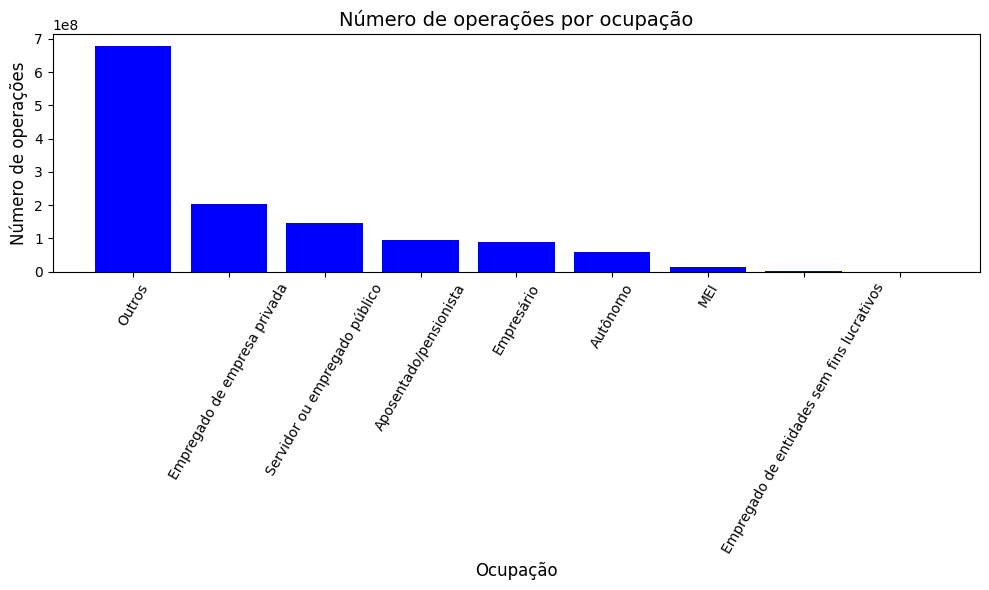

In [162]:
df_grouped = df.groupby('ct_ocupacao')['nu_numero_de_operacoes'].sum().reset_index()

df_grouped = df_grouped.sort_values(by='nu_numero_de_operacoes', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(df_grouped['ct_ocupacao'], df_grouped['nu_numero_de_operacoes'], color='blue')

plt.title('Número de operações por ocupação', fontsize=14)
plt.xlabel('Ocupação', fontsize=12)
plt.ylabel('Número de operações', fontsize=12)

plt.xticks(rotation=60)

plt.tight_layout()
plt.show()